In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Feature Engineering

In [2]:
df = pd.read_csv("overall.csv")
del df["Unnamed: 0"]

df.dropna(inplace = True)

df['year'] = df['term'].apply(lambda x: x[0:7])
df['term'] = df['term'].apply(lambda x: x[8:])
df["before_process_vacancy"].replace(0, np.nan, inplace = True)

sections = df.groupby(['course_code', 'year', 'term'])[['session']].count().reset_index()
sections = sections.rename({'session' : 'num_sections'}, axis = 1)

df = df.merge(sections, how = 'left', on = ['course_code', 'year', 'term'])


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242894 entries, 0 to 242893
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   term                    242894 non-null  object 
 1   session                 242894 non-null  object 
 2   bidding_window          242894 non-null  object 
 3   course_code             242894 non-null  object 
 4   description             242894 non-null  object 
 5   section                 242894 non-null  object 
 6   vacancy                 242894 non-null  float64
 7   opening_vacancy         242894 non-null  float64
 8   before_process_vacancy  150638 non-null  float64
 9   dice                    242894 non-null  float64
 10  after_process_vacancy   242894 non-null  float64
 11  enrolled_students       242894 non-null  float64
 12  median_bid              242894 non-null  float64
 13  min_bid                 242894 non-null  float64
 14  instructor          

Let's check the null cells

<AxesSubplot:>

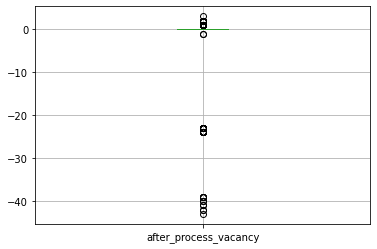

In [4]:
df[df['before_process_vacancy'].isnull()].boxplot('after_process_vacancy')

The cells appear to be recording error. Let's impute them with 0

In [5]:
df.loc[df['before_process_vacancy'].isnull(), 'before_process_vacancy'] = 0

In [6]:
df.before_process_vacancy.isnull().sum()

0

How are the bids distributed?

In [7]:
df[['before_process_vacancy', 'median_bid', 'min_bid']].describe()

,before_process_vacancy,median_bid,min_bid
count,242894.000000,242894.000000,242894.000000
mean,5.579825,8.501458,7.232290
std,9.659119,16.955614,15.195032
min,-46.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,6.000000,12.000000,10.000000
max,80.000000,496.390000,480.000000


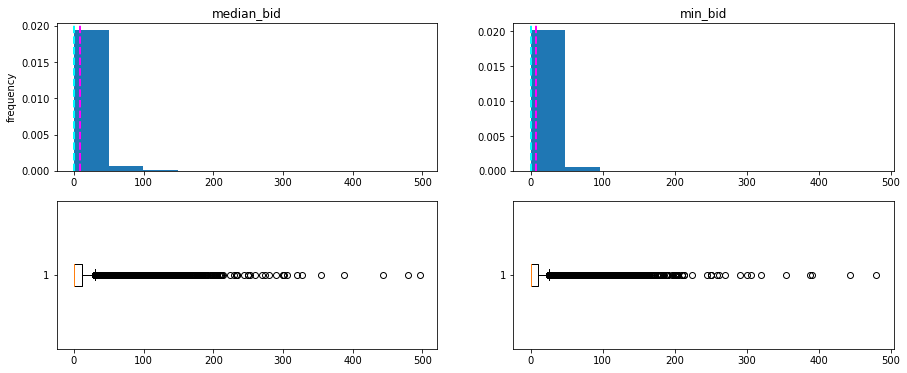

In [8]:
bids = ['median_bid', 'min_bid']

fig, ax = plt.subplots(2, 2, figsize = (15, 6))

for i in range(2):
    ax[0, i].hist(df[bids[i]], density = True)
    ax[0, i].set_title(bids[i])
    ax[1, i].boxplot(df[bids[i]], vert = False)
    ax[0, i].axvline(df[bids[i]].mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(df[bids[i]].median(), color='cyan', linestyle='dashed', linewidth=2)

ax[0, 0].set_ylabel('frequency')

plt.show()

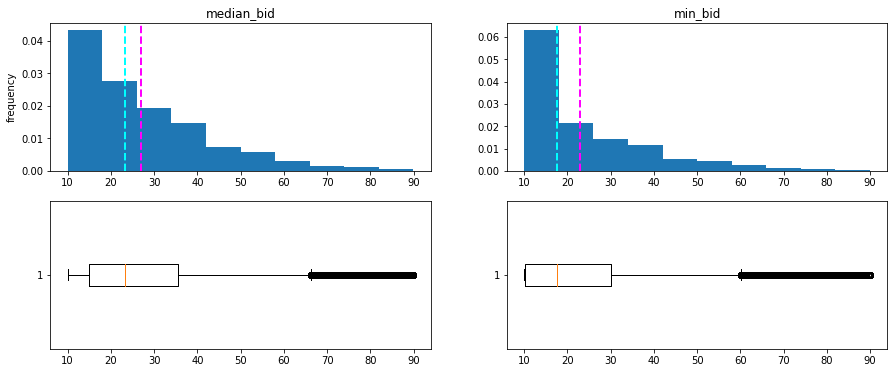

In [9]:
# Visualising it without outliers

visual = df.query('0 < median_bid < 90')

fig, ax = plt.subplots(2, 2, figsize = (15, 6))

for i in range(2):
    ax[0, i].hist(visual[bids[i]], density = True)
    ax[0, i].set_title(bids[i])
    ax[1, i].boxplot(visual[bids[i]], vert = False)
    ax[0, i].axvline(visual[bids[i]].mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(visual[bids[i]].median(), color='cyan', linestyle='dashed', linewidth=2)

ax[0, 0].set_ylabel('frequency')

plt.show()

In [46]:
# Graphing function

def corr_plot(x):
    %matplotlib inline
    fig = plt.figure()
    ax = fig.gca()
    ax.scatter(x, df['median_bid'], label = 'Median bid')
    ax.scatter(x, df['min_bid'], label = 'Min bid')
    ax.set_xlabel(x.name)
    ax.set_ylabel('Bids')
    ax.set_title('%s v. Bids' % x.name)
    plt.show()

    ax. legend
    print("{} v. Median Bid Correlation: {:.2%}".format(x.name, x.corr(df.median_bid)))
    print("{} v. Min Bid Correlation: {:.2%}".format(x.name, x.corr(df.min_bid)))
    


before_process_vacancy v. Median Bid Correlation: 21.45%
before_process_vacancy v. Min Bid Correlation: 14.51%
num_sections v. Median Bid Correlation: -10.46%
num_sections v. Min Bid Correlation: -9.29%


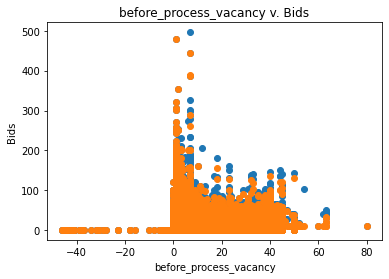

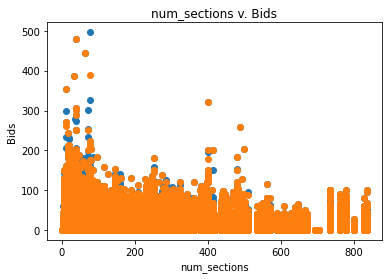

In [11]:
corr_plot(df.before_process_vacancy)
corr_plot(df.num_sections)

Some entries seem to have negative vacancies. Let's chalk those up to recording error.

In [12]:
df.loc[df['before_process_vacancy'] < 0, 'before_process_vacancy'] = 0
df.loc[df['after_process_vacancy'] < 0, 'after_process_vacancy'] = 0

# Building the predictive model

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [47]:
# results_record

model_log = pd.DataFrame(columns = ['model', 'r2_score'])

def results(model, y_true, y_pred ):
    %matplotlib inline
    fig = plt.figure()
    ax = fig.gca()
    plt.scatter(x = y_true, y = y_pred)
    ax.set_xlabel('True Y')
    ax.set_ylabel('Predicted Y')
    try:
        z = np.polyfit(x = y_true, y = y_pred, deg = 1)
        p = np.poly1d(z.flatten())
        plt.plot(y_true, p(y_true), color = 'black')
    except Exception:
        pass

    plt.show()

    print(" R2: {:.3%}\n RMSE = {:.3f}".format(r2_score(y_true, y_pred), mean_squared_error(y_true, y_pred)**0.5))

    global model_log

    model_log = model_log.append({
    'model': model,
    'r2_score': r2_score(y_true, y_pred)
    }, ignore_index = True)

In [43]:
X = df.iloc[:,[0, 1, 2, 3, 5, 8, 14, 15, 16, 17]]
Y = df.iloc[:, [12, 13, 10]]


#preprocessing for numeric features

numeric_features = [5, 9]
numeric_transformer = Pipeline(steps = [
    ('scalar', StandardScaler())
])

#preprocessing for categorical features
categorical_features = [0, 1, 2, 3, 4, 6, 7, 8]
categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Split the data 70%-30% into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 170025 rows
Test Set: 72869 rows


## Linear Regression w/o slope dummy variables

In [44]:
# Create preprocessing and training pipeline

ln = Pipeline(steps = [('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])

label = 'median_bid'

# fit the pipeline to train a linear regression model
ln.fit(X_train, Y_train[label])

predictions = ln.predict(X_test)

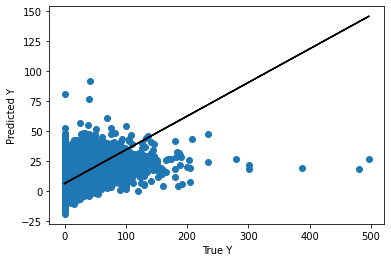

 R2: 26.723%
 RMSE = 14.583


In [45]:
results('ln', Y_test[label], predictions)

## Decision Tree w/o Slope Dummies

In [18]:
# List of values to try for max_depth:

max_depth_range = list(range(1, 20))

# List to store the accuracy for each value of max_depth:

accuracy = []
for depth in max_depth_range:
    
    dec_tree = Pipeline(steps = [('preprocessor', preprocessor),
                             ('regressor', tree.DecisionTreeRegressor(max_depth = depth, 
                             random_state = 0))])
    dec_tree.fit(X_train, Y_train)
    score = dec_tree.score(X_train, Y_train)
    accuracy.append(score)

i = accuracy.index(max(accuracy))

dec_tree = Pipeline(steps = [('preprocessor', preprocessor),
                             ('regressor', tree.DecisionTreeRegressor(max_depth = i))])
dec_tree = dec_tree.fit(X_train, Y_train)

predictions = dec_tree.predict(X_test)

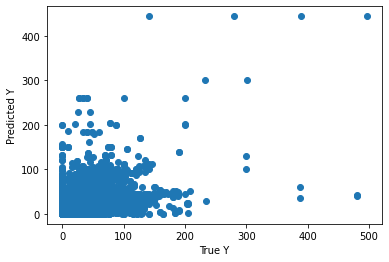

 R2: 58.035%
 RMSE = 9.804


In [19]:
results('dec_tree', Y_test, predictions)

## Random Forest w/o Slope Dummies

In [ ]:
forest = Pipeline(steps = [(
    'preprocessor', preprocessor), (
    'regressor', RandomForestRegressor()
)])

forest.fit(X_train, Y_train)

predictions = forest.predict(X_test)

In [ ]:
results('forest', Y_test, predictions)

In this segment, I try adding a dummy slope for the categorical variables to see if they improve the 3 models

## Linear Regression w Slope Dummies

In [23]:
X = df.iloc[:,[0, 1, 2, 3, 5, 8, 14, 15, 16, 17]]
Y = df.iloc[:, [12, 13, 10]]


#preprocessing manually since pipelining doesn't work with column mutation

numeric_transformer = StandardScaler()
num = numeric_transformer.fit_transform(X.iloc[:, [5, 9]])

#preprocessing for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
cat = categorical_transformer.fit_transform(X.iloc[:, [0, 1, 2, 3, 4, 6, 7, 8]]).toarray()

# Combining features
X = np.concatenate([cat, num], 1)
for i in range( num.shape[1] ):
    slope_dummy = cat[:, [3]] * num[:, [i]]
    X = np.concatenate([X, slope_dummy], 1)

# Split the data 70%-30% into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 170025 rows
Test Set: 72869 rows


In [25]:

ln_dummy = LinearRegression()
label = 'median_bid'

# fit the linear regression model

ln_dummy.fit(X_train, Y_train[label])

predictions = ln_dummy.predict(X_test)

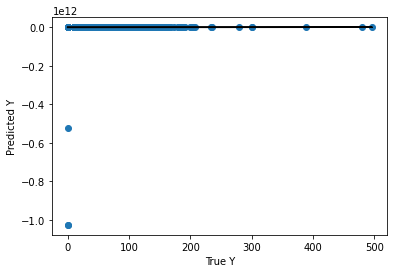

 R2: -11238531763523563520.000%
 RMSE = 5711246865.676


In [26]:
results('ln_dummy', Y_test[label], predictions)

This model seems to generate extreme outliers among the predicted values. Let's filter those out

In [36]:
model_log = model_log[model_log['model']!= 'ln_dummy']

pred = pd.DataFrame(predictions, columns = ['col'])

filter = (pred['col'] >= 0) & (pred['col'] <= 150)
true_y = Y_test.reset_index()
true_y = true_y[[label]][filter]

pred = pred[filter]

Let's try plotting the graph again with the filtered values

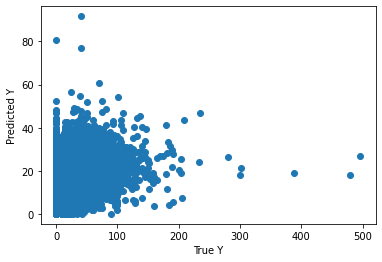

 R2: 24.452%
 RMSE = 15.931


In [37]:
results('ln_dummy', true_y, pred)

## Decision Tree w the Dummy Slopes

In [ ]:
# Identifying max_depth is infeasible at least on my local desktop

# max_depth_range = list(range(1, 20))

# accuracy = []
# for depth in max_depth_range:
    
#     dec_tree_dummy = tree.DecisionTreeRegressor(max_depth = depth, random_state = 0)

#     dec_tree_dummy.fit(X_train, Y_train)
#     score = dec_tree_dummy.score(X_train, Y_train)
#     accuracy.append(score)

# i = accuracy.index(max(accuracy))

dec_tree_dummy = tree.DecisionTreeRegressor(random_state = 0)

dec_tree_dummy.fit(X_train, Y_train)

predictions = dec_tree_dummy.predict(X_test)

In [ ]:
results('dec_tree_dummy', Y_test, predictions)

# Random Forest w Dummy Slopes

In [ ]:
forest_dummy = RandomForestRegressor()

forest_dummy.fit(X_train, Y_train)

predictions = forest_dummy.predict(X_test)

In [ ]:
results('forest_dummy', Y_test, predictions)

In [ ]:
# Models ranked best to worst

model_log.sort_values('r2_score', ascending = False)